In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,weights='imagenet')
pretrained_model.trainable = False

In [3]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = image/255
    image = tf.image.resize(image, (224, 224))
    image = image[None, ...]
    return image

image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)

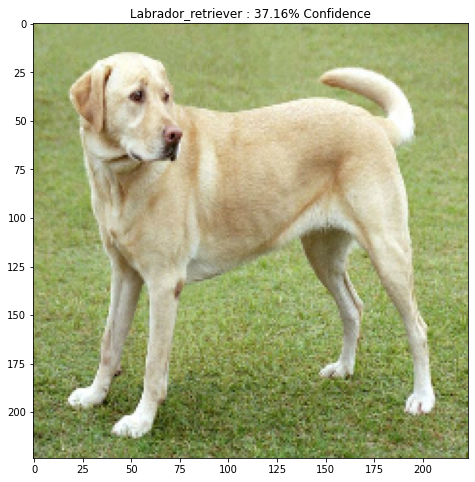

In [4]:
# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return tf.keras.applications.mobilenet_v2.decode_predictions(probs, top=1)[0][0]

image_probs = pretrained_model.predict(image)
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()


In [5]:
def create_adversarial_pattern(input_image, input_label):
    #print(input_image,input_label)
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        #print(input_label,prediction)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad


In [6]:
# Get the input label of the image.
golden_retriever_index = 207
Labrador_retriever_index = 208
Chesapeake_Bay_retriever = 209
targetlabel = tf.one_hot(golden_retriever_index, image_probs.shape[-1])
targetlabel = tf.reshape(targetlabel, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image,targetlabel)
#plt.imshow(perturbations[0])
#print(image)

In [7]:
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0])
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,label, confidence*100))
    plt.show()

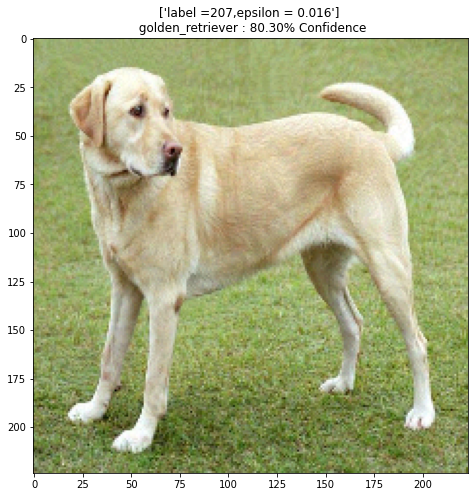

In [18]:
epsilon = 4/256
#print(epsilons)
confidences = []
target = []
targetlabel = tf.one_hot(golden_retriever_index, image_probs.shape[-1])
targetlabel = tf.reshape(targetlabel, (1, image_probs.shape[-1]))
perturbations = create_adversarial_pattern(image, targetlabel)
adv_x = image - epsilon*perturbations
adv_x = tf.clip_by_value(adv_x, 0, 1)
_, label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))
description = [('label ={:d},epsilon = {:0.3f}'.format(golden_retriever_index,epsilon))]
display_images(adv_x,description)
fake_image = adv_x

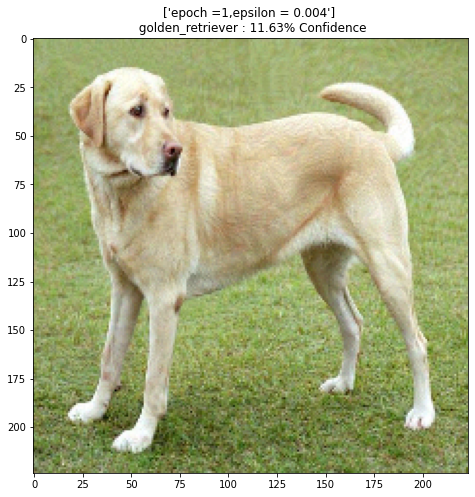

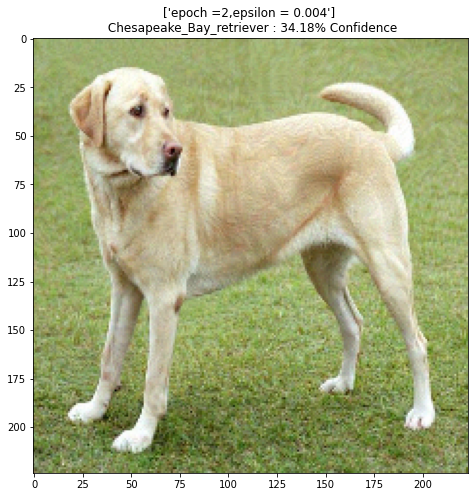

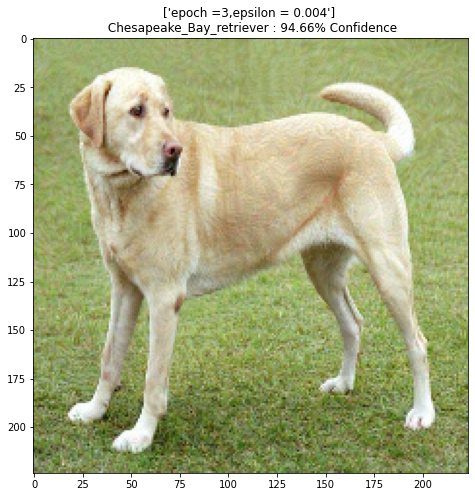

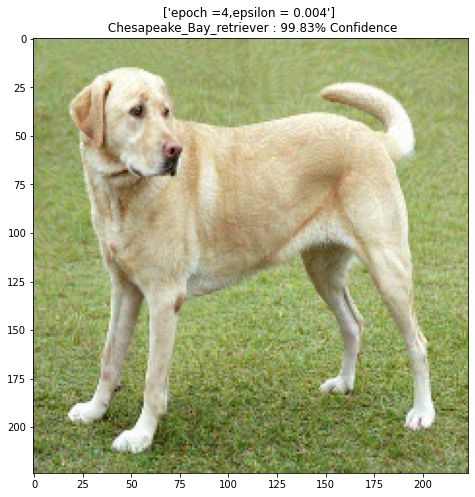

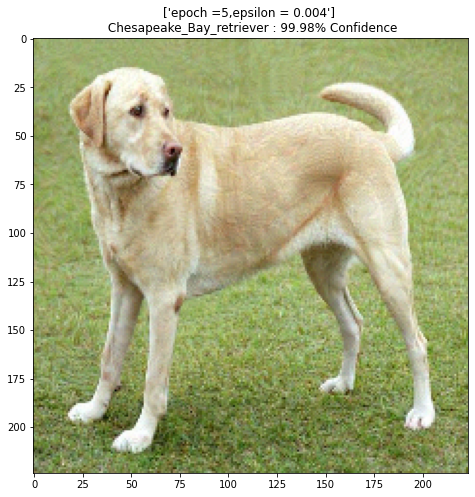

In [28]:
epsilon = 1/256
epochs = 5
img = fake_image
labels = []
confidences = []
for i in range(epochs):
    targetlabel = tf.one_hot(Chesapeake_Bay_retriever, image_probs.shape[-1])
    targetlabel = tf.reshape(targetlabel, (1, image_probs.shape[-1]))
    perturbations = create_adversarial_pattern(img, targetlabel)
    adv_x = img - epsilon*perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    img = adv_x
    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))
    labels.append(label)
    confidences.append(confidence)
    description = [('epoch ={:d},epsilon = {:0.3f}'.format(i+1,epsilon))]
    display_images(adv_x,description)


golden_retriever 0.116293795
Chesapeake_Bay_retriever 0.34181103
Chesapeake_Bay_retriever 0.9466353
Chesapeake_Bay_retriever 0.99832255
Chesapeake_Bay_retriever 0.9998294


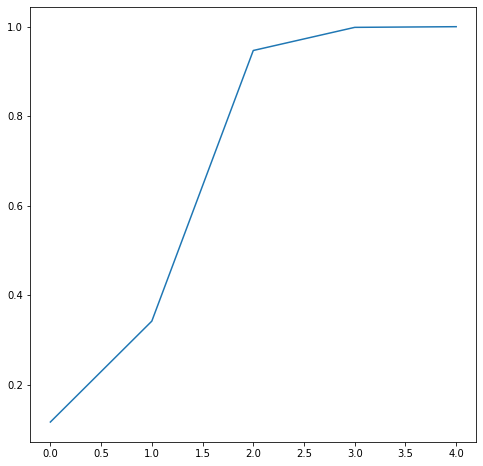

In [29]:
for label,confidence in zip(labels,confidences):
    print(label,confidence)
plt.plot(range(5),confidences)
plt.show()

In [35]:
epsilon = 4/256
#print(epsilons)
confidences = []
targets = []
for i in range(1000):
    targetlabel = tf.one_hot(i, image_probs.shape[-1])
    targetlabel = tf.reshape(targetlabel, (1, image_probs.shape[-1]))
    perturbations = create_adversarial_pattern(fake_image, targetlabel)
    adv_x = fake_image - epsilon*perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))
    description = [('label ={:d},epsilon = {:0.3f}'.format(i,epsilon))]
